# Case Study 15 - Minimizing Cost - Final Project

Allen Ansari, Chris Ballenger, Shantanu Godbole, Chad Madding

DS 7333 Quantifying the World

August 10, 2020

## Table of Content

## Abstract

## Introduction
Predictions can be easily measured if we are only worried about True Postives and True Negatives. However, there can be implications in a model if we failed to classify correctly.  In the hospital industry you may find that misclassifying a patient as having cancer can be very costly for that patient. There may be additional tests and accrued cost to the the patient due to a false positves.  On the other hand, there could be a large legal settlement if we failed to fix an issue in a car.  It might be cheaper to identify more false positives and fix the repairs, even if repair was unnecessary, instead of ignoring the issue (false negative).

In our research, we examine a business case study with a target variable `y`.  All the data provided has been masked, including the target variable. The instructions we were given is to minimize cost to our client.  Cost is associated only when we failed to to predict the our response variable correclty.  Each false positive will cost our client $\$$10 and each false negative will cost $\$$500.

We developed two models, neural network and an XGBoost classifier model. Both models use tunning techniques and were measured based on the Area Under the Curve (AUC).  We selected AUC as the scorer due to calculating a sliding threshold of True Postivies and False Positives.  Recall was considered as a secondary measurment.  Our nueral network model achieved a minimum cost of **$\$$XXX** and our stacked classifier's minimum cost was **$\$$XXX**.

Our remaining paper will go through the series of data scientist best practices.  We will first determine what our best measurment should be for modeling.  Next we will analyze the data and imputate missing values.  Our modeling sections will include two types of models, results, and explanation of features.

## Measurments
We know that it will cost our client $\$$10 if we incorrectly predict a customer positive.  In fact, using 20$\%$ of the data from our masked dataset, it would cost a maximum of $\$$320,000 if everything was predicted positive.  This amount should be our base line to beat.  In order to minimize our cost we need to find the optimal threshold of our predicted values to be classified as 1 or 0 (Default is 0.5).  It is clear our client will accept false positve (FP) given the low cost and wants to avoid false negatives (FN) (Table 1), therfore lowering our threshold should be considered.

<table>
    <tr>
        <td style="text-align:center" colspan=4>Confusion Matrix</td>
    </tr>
    <tr>
        <td style="text-align:center" colspan=2> </td>
        <td style="text-align:center" colspan=2>Prediction</td>
    </tr>
    <tr>
        <td style="text-align:center" colspan=2> </td>
        <td style="text-align:center">Negative (y=0)</td>
        <td style="text-align:center">Positive (y=1)</td>
    </tr>
    <tr>
        <td style="text-align:center" rowspan=2>Truth</td>
        <td style="text-align:center">Negative (y=0)</td>
        <td style="padding: 15px;text-align:center">True Negative (\$0)</td>
        <td style="padding: 15px;text-align:center">False Positive (\$10)</td>
    </tr>
    <tr>
        <td style="text-align:center">Positive (y=1)</td>
        <td style="padding: 15px;text-align:center">False Negative (\$500)</td>
        <td style="padding: 15px;text-align:center">True Positive (\$0)</td>
    </tr>
</table>

*Table 1: Confusion Matrix of what each true and false classification will cost our client.*


Area under the Curve (AUC) is a calculated value of the space under an Receiver Operating Characteristic (ROC) curve.  The ROC Curve can show us a relationship between the specifitvity and sensitivty of our model's performance.  Since we are not as concerned with accuracy and more concerned with minizing false negative (Table 1), we consider AUC as our scorer for optimizing our models.

False negatives can cost our client \$500 for each record we failed to classify correctly.  As a result, we want to minimze this value. Recall (eq. 1) can help us measure the number of false negative (FN) compared to our true positives.  We would like to minize FN, which will increase our Recall score.


\begin{equation*}
Recall = \frac{tp}{tp + fn}
\end{equation*}

*Equation 1: Recall*

The below function is used to calculate the cost based on the threshold we set.

In [196]:
from sklearn import metrics
def calcCost(truth, probabilities, threshold, fp = 10, fn = 500):
    y_hat = (probabilities > threshold).astype(int)
    mt = metrics.confusion_matrix(truth, y_hat)
    acc = metrics.accuracy_score(truth, y_hat)
    recall = metrics.recall_score(truth, y_hat)
    return {
        "probability":threshold,
        "accuracy": acc,
        "recall": recall,
        "fn":mt[1,0],
        "fn_cost":mt[1,0]*fn,
        "fp":mt[0,1],
        "fp_cost":mt[0,1]*fp
    }

## Exploratory Data Analysis
Our masked data includes 160,000 rows and 51. The columns consist of 3 catagorical (`object`), 47 continous (`float64`), and 1 response (`int64`) variable. Columns `x32` and `x37` had special characters that were required to be removed.

In [24]:
import pandas as pd
import os
project_folder = "."
# read in the dataset
data = pd.read_csv(os.path.join(project_folder,"data",'final_project.csv'))

#Remove special characters
data["x32"] = data.x32.apply(PerSign)
data["x37"] = data.x37.apply(DollarSign)

print("Shape:", data.shape)
print("\n")
print("Data Types")
print(data.dtypes.value_counts())

Shape: (160000, 51)


Data Types
float64    47
object      3
int64       1
dtype: int64


### Response Variable
The response variable we will predict on is `y`. The percentage of the value `1` is approximatley 40\% of the data and 60\% for `0`. There are more records for the response variable `0` and we should proceed with caution to prevent predicting false negatives.  We will consider adjusting the threshold to lower cost.

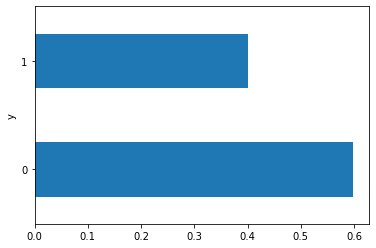

In [67]:
import matplotlib.pyplot as plt
df = data.groupby(["y"])["x0"].size()
df.div(df.sum()).plot.barh()
plt.show()

*Figure 1: Percentage of our response variable y*

### Continuous Variables
All the continuous variables showed a normal distribution (Appendix [2](#Appendix-2:-EDA-Histogram)). During our assessment we found several features where the mean is different between the two response variables. Visually, features that show a different between `0` and `1` are a good indication the features will help improve our prediction.

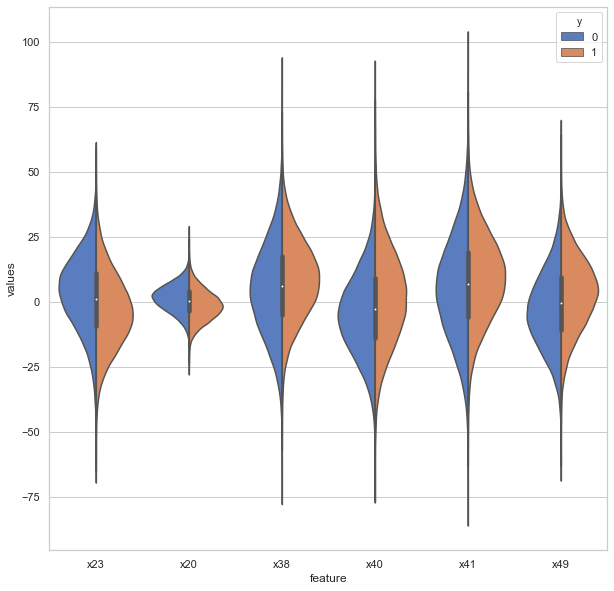

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ["x23", "x20", "x38", "x40", "x41", "x49"]
feats_df = [pd.DataFrame({"y":data.y,"feature":[col]*len(data), "values":data[col].values}) for col in cols]
df = pd.concat(feats_df, axis=0)

fix, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="feature", y="values", hue="y", data=df, palette="muted", split=True, ax=ax)
plt.show()


*Figure 2: Violin Plot to compare differences between response variable of several features*

There are some differences in a features where the mean changes slightly between `0` and `1` (Figure 2).  Additional details on feature important can be found in our explanation of the model.

### Catagorical Variables
There are three categorical variables, `x24`, `x29`, and `x30`.

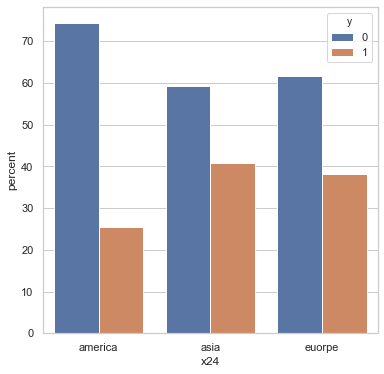

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

df = data.groupby("x24")["y"].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fix, ax = plt.subplots(figsize=(6,6))
sns.barplot(data = df, x="x24",y='percent',hue="y", ax=ax)
plt.show()

*Figure 3: Percentage of response for feature x24*

Feature `x24` has 3 values and represent a location of each record. `asia` having the largest percentage of 86\% (Table 2).  Figure 3 provides insight that the value of `america` has about 25\% being identified as a `1`.  Remaining two features are approximately aligned with the response variable.

In [137]:
print(data.x24.value_counts() / data.x24.value_counts().sum())

asia       0.868683
euorpe     0.103381
america    0.027936
Name: x24, dtype: float64


*Table 2: Percentage of values for feature x24*

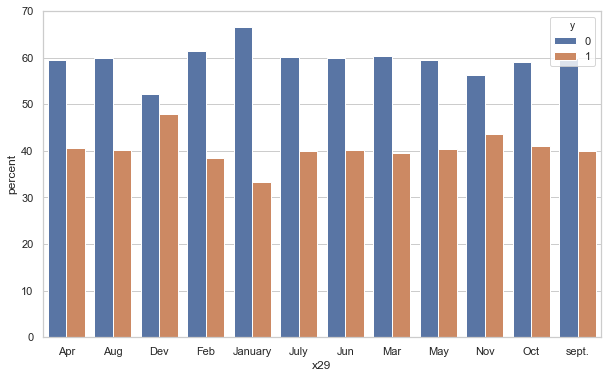

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

df = data.groupby("x29")["y"].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fix, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df, x="x29",y='percent',hue="y", ax=ax)
plt.show()

*Figure 4: Percentage of response for feature x29*

`x29` provides us details about the month our record takes place in.  Visually, there is no large evidence any of the values show a strong relationship to either response variable, with majority of months hovering around 40\%. Months `January` and `Dev` (assuming December) show slight differences, but these two features has the least frequency (Table 3).

In [144]:
print( data.x29.value_counts().tail() )

Mar        1231
Nov         337
Feb         140
Dev          23
January       9
Name: x29, dtype: int64

*Table 3: Bottom 5 Count of values for feature x29*

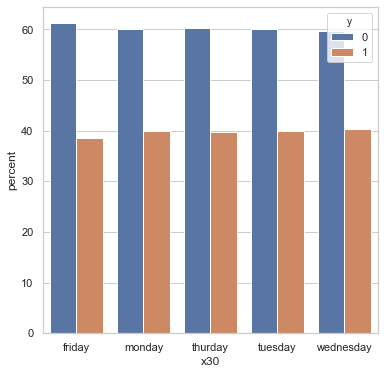

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

df = data.groupby("x30")["y"].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fix, ax = plt.subplots(figsize=(6,6))
sns.barplot(data = df, x="x30",y='percent',hue="y", ax=ax)
plt.show()

*Figure 5: Percentage of response for feature x30*

`x30` is another feature that tells us the time record was recorded, day of week.  All the values show no visual evidence one response value is an improvement over another.

### Highly Correlated Values
Last data exploration we did was evaluation highly correlated values and remove features that are similar (threshold of 0.95).

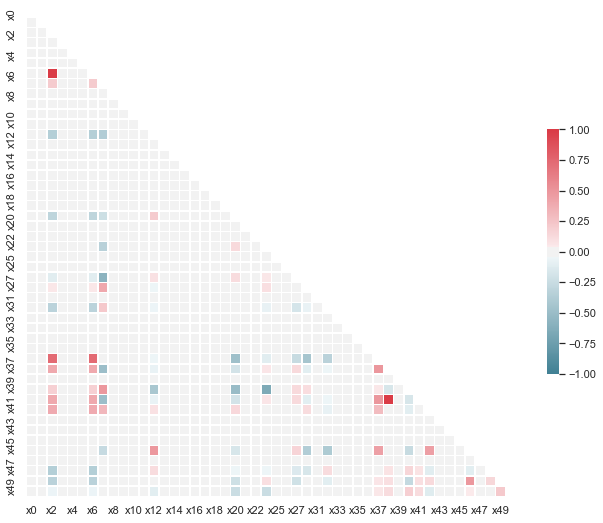

In [152]:
#Code from https://shravan-kuchkula.github.io/ml/Binary-Classification/#remove-highly-correlated-variables
import matplotlib.pyplot as plot
import seaborn as sns
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

*Figure 6: Correlation Heatmap of each continous variable*

We found two visual pairs that are highly correlated, `x6` \& `x2` and `x41` \& `x38`. Below's code was excuted to exliminate 1 column for each pair.

In [153]:
data_reduced = reduce_features(data, True)

There are  2  field correlations > 95%.


,drop,keep,Correlation
0,x6,x2,1.0
1,x41,x38,1.0


Dropping the following  2  highly correlated fields.

*********Before: Dropping Highly Correlated Fields*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 51 entries, x0 to y
dtypes: float64(47), int64(1), object(3)
memory usage: 62.3+ MB


None


*********After: Dropping Highly Correlated Fields**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 49 entries, x0 to y
dtypes: float64(45), int64(1), object(3)
memory usage: 59.8+ MB


## Data Imputation
There are many strategies for data inputation. For our dataset, we opted for 2 strategies.  Each missing catagorical value will have default `NA` and our continuous variables will be imputed with `KNNImputer`.

In Case Study 10, our team found that `KNNImputer` performed better for each variable over using the mean.  In order to impute our variables we will first train our `KNNImputer` on training dataset.  Going forward all our models will us this dataset to `fit` a model and validation will be done on our 20% holdout set.

### Creating a holdout test set

In [162]:
from sklearn.model_selection import train_test_split

columns = data_reduced.dtypes
del columns["y"]
cols_obj = columns[columns==object].index
cols_flt = columns[columns!=object].index

data_train, data_test, y_train, y_test = train_test_split(
    data_reduced.iloc[:,:-1], data_reduced.iloc[:,-1], 
    test_size=0.20, random_state=76244
)

### Continuous Variable Imputation
The below code shows us how we imputed our continuous variables. `n_neighbors` is defined by square root of total rows.

In [163]:
from sklearn.impute import KNNImputer
import pickle

try:
    with open(os.path.join(project_folder,"models","imputer.pkl"),"rb") as f:
        imputer = pickle.load(f)
except:
    print("Model does not exist, fitting model")
    k = int(len(data_train)**(1/2))
    imputer = KNNImputer(n_neighbors=k)
    imputer.fit(data_train[cols_flt.values])
    with open(os.path.join(project_folder,"models","imputer.pkl"),"wb") as f:
        pickle.dump(imputer, f)

X_train_flt = imputer.transform(data_train[cols_flt].values)
X_test_flt = imputer.transform(data_test[cols_flt].values)

print("X_train_flt",X_train_flt.shape)
print("X_test_flt",X_test_flt.shape)

X_train_flt (128000, 45)
X_test_flt (32000, 45)


### Categorical Variables
One popular technique is use the mode (highest frequency) to impute missing values. However, given the low count and inability to find a pattern to impute these values, we opted for a default `NA` value.

In [167]:
print(data.loc[:,data.dtypes==object].isna().sum(axis=0))
print("Table 4: Total number of values that will be replaced with a default NA")

data_train[cols_obj] = data_train[cols_obj].fillna(str("NA"))
data_test[cols_obj] = data_test[cols_obj].fillna(str("NA"))

x24    28
x29    30
x30    30
dtype: int64
Table 4: Total number of values that will be replaced with a default NA


Each categorical variable will also be one-hot encoded.  We will fit our model using only values from our training set and transform our test data with these features.

In [169]:
from sklearn.preprocessing import OneHotEncoder

try:
    with open(os.path.join(project_folder,"models","encoder.pkl"),"rb") as f:
        encoder = pickle.load(f)
except:
    print("Model does not exist, fitting model")
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(data_train[cols_obj].values)
    with open(os.path.join(project_folder,"models","encoder.pkl"),"wb") as f:
        pickle.dump(encoder, f)

X_train_obj = encoder.transform(data_train[cols_obj].values)
X_test_obj = encoder.transform(data_test[cols_obj].values)

print("X_train_obj",X_train_obj.shape)
print("X_test_obj",X_test_obj.shape)

X_train_obj (128000, 23)
X_test_obj (32000, 23)


Finally we merge the continuous variables with our categorical variables to build a final train \ test dataset.

In [193]:
from scipy.sparse import hstack
import pickle

columns = list(cols_flt)
columns.extend(list(encoder.get_feature_names(cols_obj)))

X_train = hstack([X_train_flt, X_train_obj])
X_test = hstack([X_test_flt, X_test_obj])

print("X_train",X_train.shape)
print("X_test",X_test.shape)

# with open(os.path.join(project_folder,"data","train_test.pkl"), "wb") as f:
#     pickle.dump((X_train, X_test, y_train, y_test, columns), f)

X_train (128000, 68)
X_test (32000, 68)


In [177]:
pd.DataFrame(X_train.toarray(), columns = columns)

,x0,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x29_NA,x29_Nov,x29_Oct,x29_sept.,x30_NA,x30_friday,x30_monday,x30_thurday,x30_tuesday,x30_wednesday
0,-0.621765,0.493737,-1.369491,3.127702,-10.827658,23.272388,-21.694432,-1.661046,-1.306585,5.027160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.318548,0.898655,5.799884,3.486426,-9.500385,3.412299,-3.505052,0.821401,-7.083498,-0.173855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.262392,-2.600492,-3.855814,-3.879275,-6.392450,-14.854056,-29.456374,-3.855477,-6.680866,-13.994244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.633813,-2.789859,0.747909,8.457432,-9.919461,1.499006,11.877818,0.050451,8.679347,8.892267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.748939,0.086249,3.658972,-2.464457,3.464528,-13.736211,-22.916991,0.077414,-5.927720,-2.098051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127995,-0.167820,-6.198465,9.129126,1.442089,-11.158144,-4.666215,-5.212351,19.882822,-8.636019,-4.230678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127996,-0.735993,-4.929205,6.052769,-5.794691,-3.300905,10.774204,57.540916,9.960565,-4.611320,2.600360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127997,0.051052,-7.169340,11.265778,9.581166,2.419735,-2.846703,-17.652257,1.146228,-11.003736,3.549505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127998,0.591168,-1.151029,-18.105518,0.188311,-8.867874,0.474659,-34.208501,-11.841619,5.855601,0.162302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modeling
We built three models to determine which one would be our best model for the purpose of minimizing false negatives.
* Stacked Classifier with `KNNClassifier`, `RandomForestClassifier`, and `LogisticRegression`
* `XGBoost` Classifier
* Neural Network Model

Each model used a standard scaler place all values between -1 and 1.  For our Stack Classifier Model and XGBoost we used 3-fold Cross-Validation during hyper parameter tuning.

In [180]:
import pickle

with open(os.path.join(project_folder,"data","train_test.pkl"), "rb") as f:
    X_train, X_test, y_train, y_test, columns = pickle.load(f)
    
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)
print(columns)

X_train (128000, 68)
y_train (128000,)
X_test (32000, 68)
y_test (32000,)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x25', 'x26', 'x27', 'x28', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x24_NA', 'x24_america', 'x24_asia', 'x24_euorpe', 'x29_Apr', 'x29_Aug', 'x29_Dev', 'x29_Feb', 'x29_January', 'x29_July', 'x29_Jun', 'x29_Mar', 'x29_May', 'x29_NA', 'x29_Nov', 'x29_Oct', 'x29_sept.', 'x30_NA', 'x30_friday', 'x30_monday', 'x30_thurday', 'x30_tuesday', 'x30_wednesday']


In [182]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train.toarray())
X_test_array = scaler.transform(X_test.toarray())

### Stacking Classifier
The first modeled used Random Forest, KNN Classifier, and Logistic Regression. The first thing we did was hyper tune each model individual to determine the best parameters (Appendix [4](#Appendix-4:-Stacking-Code)).  Once we found our optimal parameters for each model, we designed our stacking classifier test.  We trained each combination pair and all three classifiers together.

```
ParamDict = {
    'RandomForestClassifier': {
        "min_samples_split": [2,3,4],
        "n_estimators": [10,12,15],
        "max_features": ['auto', 'sqrt', 'log2']},
    'LogisticRegression': {
        "tol": [0.001,0.01,0.1], 
        "C": [0.001, 0.01, 1, 3, 100],
        "penalty":["none","l2"]},
    'KNeighborsClassifier':{
        "n_neighbors": [4,5,6,10], 
        "leaf_size":[20,30,40],
        "algorithm":["auto", "ball_tree", "kd_tree"]}} 
```

*Parameters used for tuning our model*

`KNNClassifier` performed best with `n_neighbros` set to 10 and worst as k decreases. In our `LogisticRegression` the `penalty` for `l2` performed best except with `C` was set to `0.001`. `RandomForestClassifier` `n_estimator` improved its score as the value increases and `max_features` of `log2` performed worst in all combinations.

In [ ]:
import pandas as pd

gridsearch_df = pd.read_csv("data/GridSearch_result.csv")

display(gridsearch_df)

*Table 5: Combination of all our gridsearch scores*

The best model included all three classifiers with an AUC of 0.96. Below code shows the output of our final trained model.

In [190]:
from sklearn.ensemble import StackingClassifier 
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=76244)
    scores = cross_val_score(model, X_train_array, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores
for combo in combo_classifiers:
    clf = StackingClassifier( estimators=combo, final_estimator=LogisticRegression(max_iter=1000,random_state=76244)
                             ,cv=2,n_jobs=-1,verbose=2)
    score = evaluate_model(model=clf)
    print(f"AUC of stack {combo}: {score.mean():.3f}")

AUC of stack (('rf', RandomForestClassifier(max_features='sqrt', min_samples_split=4,
                       n_estimators=15, random_state=76244)), ('lr', LogisticRegression(C=1, max_iter=1000, random_state=76244, tol=0.1))): 0.958
AUC of stack (('rf', RandomForestClassifier(max_features='sqrt', min_samples_split=4,
                       n_estimators=15, random_state=76244)), ('knn', KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10))): 0.959


KeyboardInterrupt: 

**Run CLF save pickle**

### XGBoost
XGBoost was hyper tuned with four parameters (Appendix [5](#Appendix-5:-XGBoost-Parameters)).  The best parameters that were selected are `max_depth`:10, `n_estimators`:140, `learning_rate`:0.2, and `min_child_weight`:8.

```
parameters = {
    'max_depth': range (1, 12, 3),
    'n_estimators': range(60, 220, 80),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight':[5,6,7,8]
}
```

**Discuss best and worst parameters**

Training our model with a `early_stopping_rounds` equal to 10, our model stoped after 93 rounds.  Our AUC for the validation dataset after 83 rounds was 0.975.

In [192]:
from xgboost import XGBClassifier

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=8, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=76244, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=76244, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

eval_set = [(X_test_array, y_test)]
model.fit(X_train_array, y_train, early_stopping_rounds=10, eval_metric="aucpr", eval_set=eval_set, verbose=True)

[19:38:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1588600962499/work/src/learner.cc:328: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.87894
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.91237
[2]	validation_0-aucpr:0.92263
[3]	validation_0-aucpr:0.93059
[4]	validation_0-aucpr:0.93827
[5]	validation_0-aucpr:0.94264
[6]	validation_0-aucpr:0.94452
[7]	validation_0-aucpr:0.94818
[8]	validation_0-aucpr:0.95056
[9]	validation_0-aucpr:0.95276
[10]	validation_0-aucpr:0.95589
[11]	validation_0-aucpr:0.95749
[12]	validation_0-aucpr:0.95877
[13]	validation_0-aucpr:0.96028
[14]	validation_0-aucpr:0.96185
[15]	validation_0-aucpr:0.96269
[16]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=76244, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=76244, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Artificial Nueral Network
Explain our layers, what worked, what did not work

In [201]:
from tensorflow.keras.models import load_model
model = load_model('models/model_85.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               34500     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               150300    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)               0

### Cost Optimization

* Compare cost
* COmpare auc
* compare recall
* plot results

## Feature Explanation

## Conclusion

## Appendix

### Appendix 1: Data Functions

In [19]:
def PerSign(var):
    var = str(var).replace('%', "")
    return float(var)

def DollarSign(var):
    var = str(var).replace('$', "")
    return float(var)

### Appendix 2: EDA Histogram

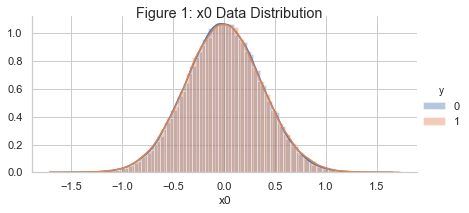

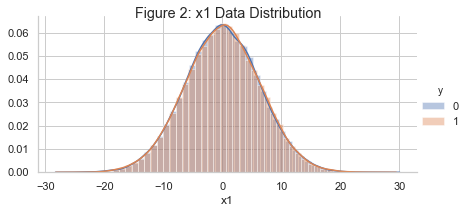

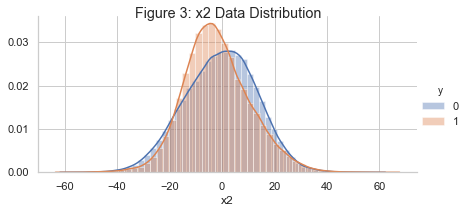

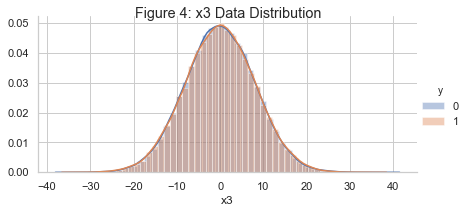

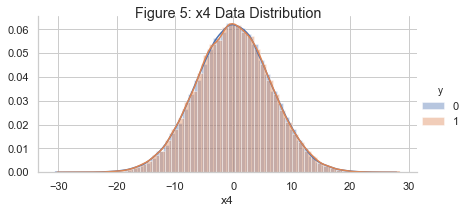

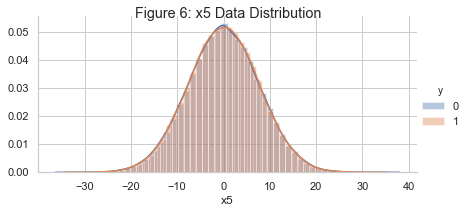

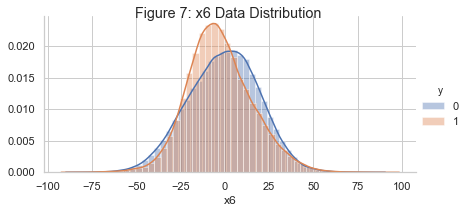

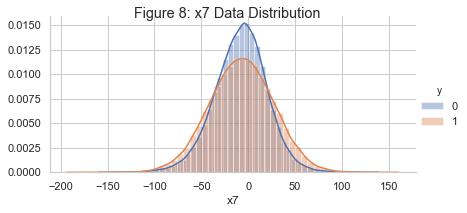

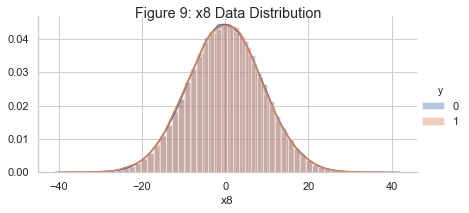

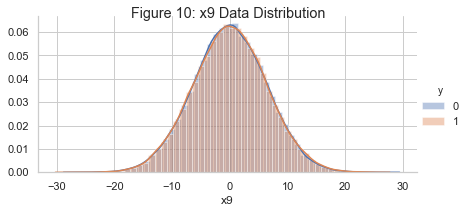

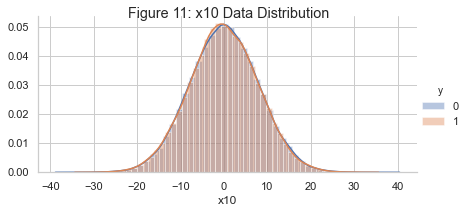

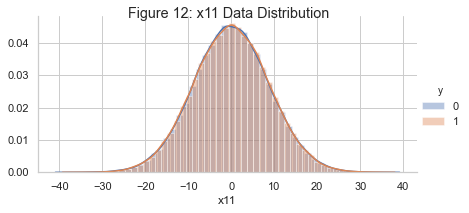

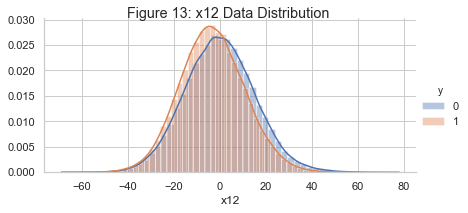

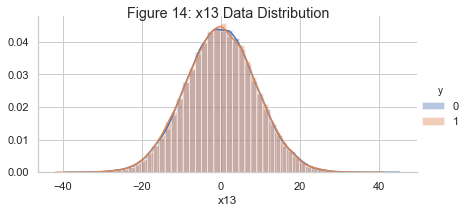

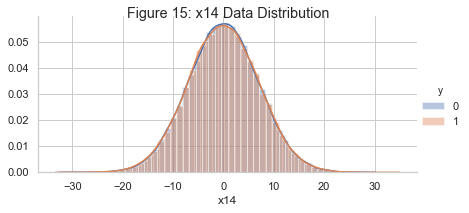

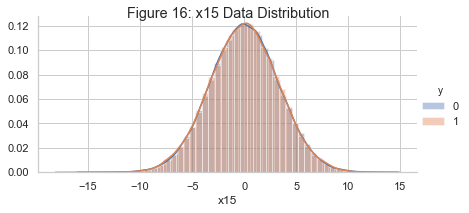

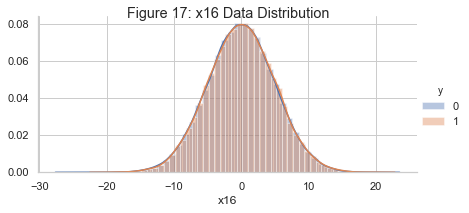

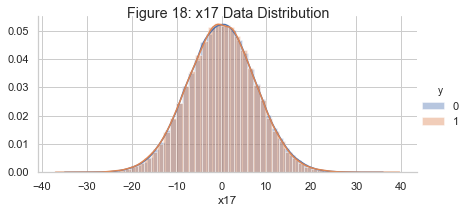

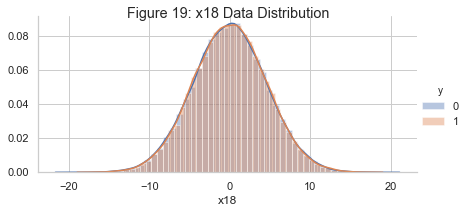

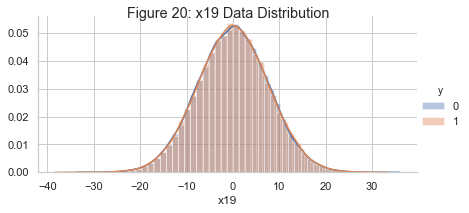

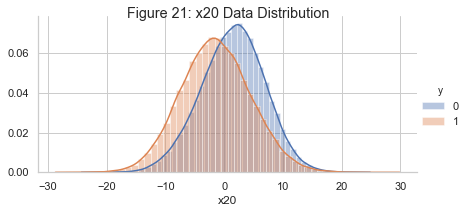

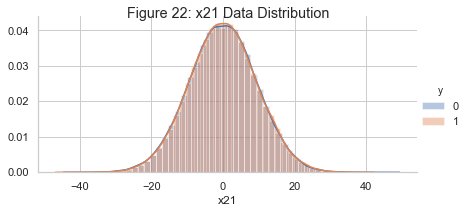

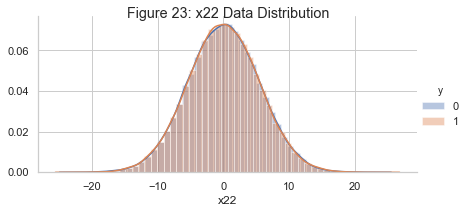

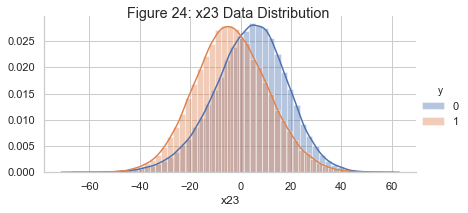

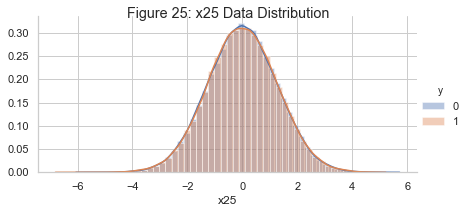

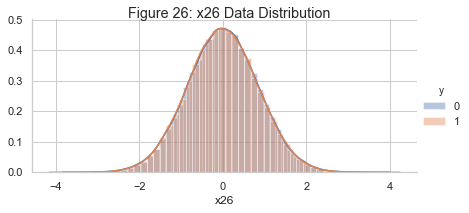

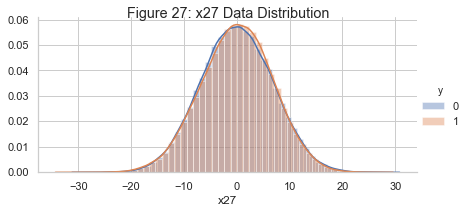

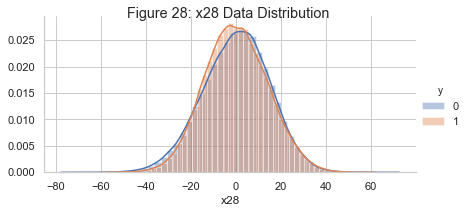

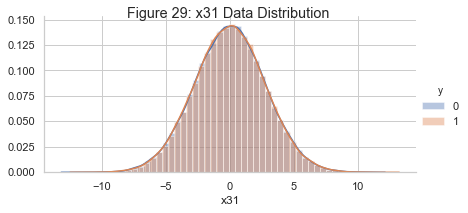

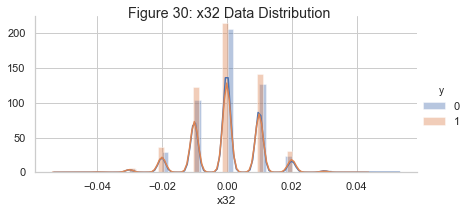

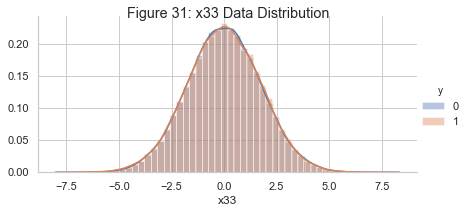

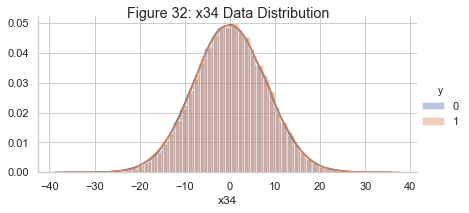

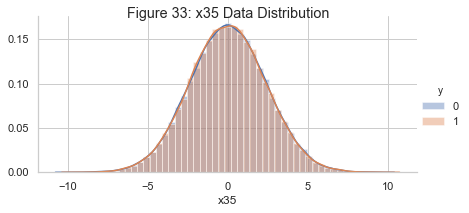

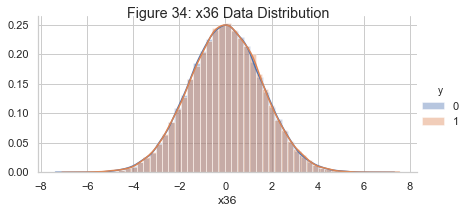

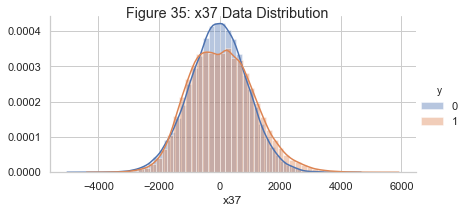

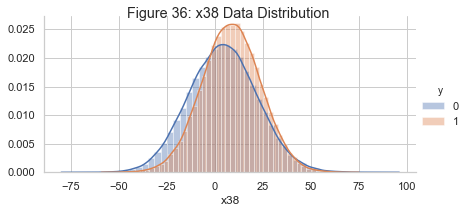

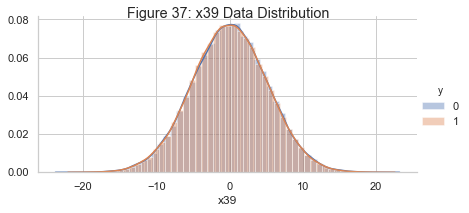

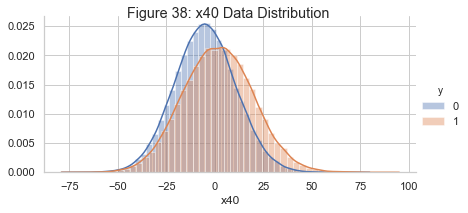

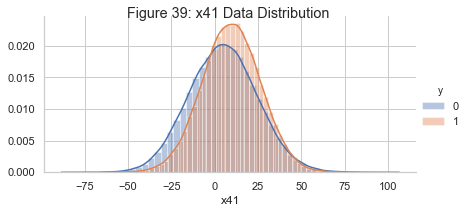

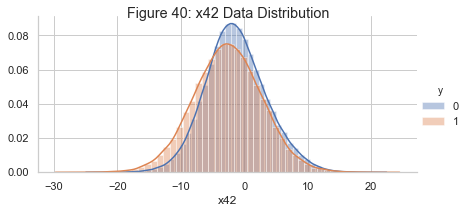

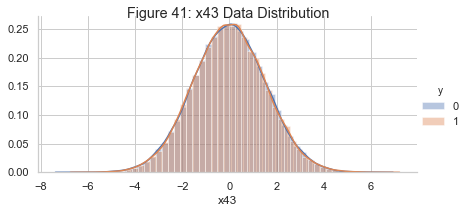

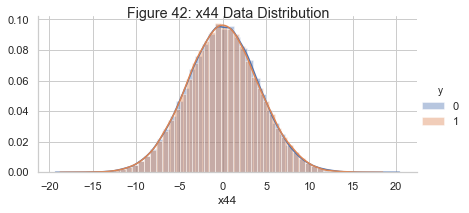

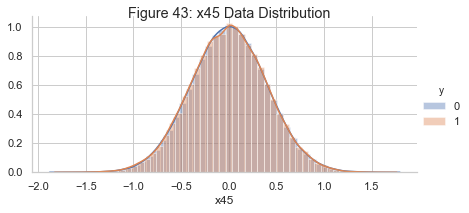

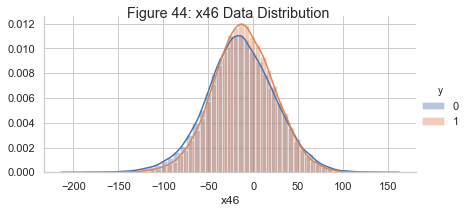

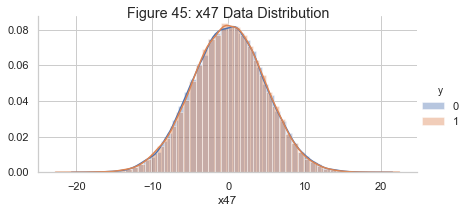

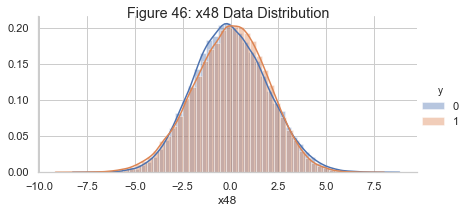

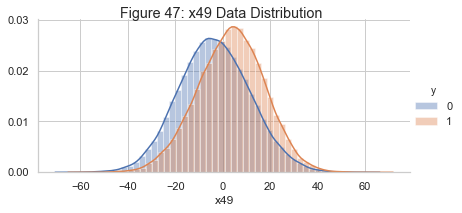

In [71]:
# https://nbviewer.jupyter.org/github/yaowser/qtw/blob/master/Yao%20Angelov%20Kruse%20MSDS%207333%20402%20CS15%20Final%20Project.ipynb
import matplotlib.pyplot as plot
import seaborn as sns; sns.set(style="whitegrid")

plt.rcParams['figure.max_open_warning']=40
colnames=list(data.drop(['y'], axis=1).select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(data, hue='y',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Data Distribution"]))))
    plt.show()

### Appendix 3: Removing Highly Correlated Values

In [149]:
import numpy as np
def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['drop'] = upper.columns[x[1]]
    cf['keep'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['drop'][i]][cf['keep'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['drop'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df

### Appendix 4: Stacking Code

```
ModelsDict = {'RandomForestClassifier':RandomForestClassifier(random_state=76244), 
            'LogisticRegression': LogisticRegression(max_iter=1000,random_state=76244), 
            'KNeighborsClassifier': KNeighborsClassifier()
            }

ParamDict = {'RandomForestClassifier': {"min_samples_split": [2,3,4],
                                        "n_estimators": [10,12,15],'max_features': ['auto', 'sqrt', 'log2'] },
            'LogisticRegression': {"tol": [0.001,0.01,0.1], "C": [0.001, 0.01, 1, 3, 100],
                                  "penalty":["none","l2"]},
           'KNeighborsClassifier': {"n_neighbors": [4,5,6,10], 
                                    "leaf_size":[20,30,40], "algorithm":["auto", "ball_tree", "kd_tree"]}}                     

class MyGridSearch:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring= "roc_auc", refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs  
            
       

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return {**params,**d}

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
        return rows

# run the Grid Search evaluation method and export results in a table
GSresult = MyGridSearch(ModelsDict, ParamDict)
GSresult.fit(X_train_array, y_train, scoring='roc_auc', n_jobs=-1)

print("Grid Search Result, Below is the top 5 classifiers and hyperparameter sets:")

results=GSresult.score_summary()
print(results)
```

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import itertools

estimators = [('rf', RandomForestClassifier(random_state=76244,max_features='sqrt',min_samples_split=4,n_estimators=15)),
              ('lr',  LogisticRegression(max_iter=1000,random_state=76244,C=1,tol=0.1)),
              ('knn',KNeighborsClassifier(algorithm='kd_tree',leaf_size=30,n_neighbors=10))]
    
combo_classifiers = []
for ii in range(2, len(estimators)+1):
    for subset in itertools.combinations(estimators, ii):
        combo_classifiers.append(subset)

## Appendix 5: XGBoost Parameters

```
parameters = {
    'max_depth': range (1, 12, 3),
    'n_estimators': range(60, 220, 80),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight':[5,6,7,8]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 2,
    verbose=True
)

grid_search.fit(X_train_array, y_train)
```

### Appendix 6: ANN

```
model = Sequential()

model.add(tf.keras.Input(shape=(68,)))

model.add(Dense(500))
model.add(LeakyReLU())
model.add(Dropout(rate=0.2))

model.add(Dense(300))
model.add(LeakyReLU())

model.add(Dense(100))
model.add(LeakyReLU())

model.add(Dense(1,activation = 'sigmoid'))

model.summary()
```

In [198]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.utils import normalize, to_categorical
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import initializers
from tensorflow.keras.layers import LeakyReLU